# Perplexity ratio score exploratory data analysis

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

import configuration as config
import functions.data_manipulation as data_funcs
import functions.plotting as plot_funcs

/mnt/arkk/llm_detector/benchmarking


## 1. Benchmark data

In [2]:
# Load the data
data_df = pd.read_json(f'{config.BENCHMARKING_DATA_PATH}/perplexity_ratio_model_benchmark.jsonl', lines=True, orient='records')

# Translation dict for column names
column_renaming_dict = {
    'hf_model_string': 'Scoring model',
    'perplexity_ratio_score': 'Perplexity ratio score',
    'perplexity': 'Perplexity',
    'cross-perplexity': 'Cross-perplexity',
    'length_words': 'Input length (words)',
    'length_tokens': 'Input length (tokens)',
    'data_source': 'Data source',
    'generating_model': 'Generation model',
    'reader_model': 'Reader model',
    'writer_model': 'Writer model',
    'reader_device': 'Reader device',
    'writer_device': 'Writer device',
    'author': 'Author',
    'device_map': 'Device',
    'iteration': 'Iteration',
    'text': 'Text'
}

# Translation dict for string values
value_renaming_dict = {
    'cuda:1': 'NVIDIA K80',
    'cuda:2': 'NVIDIA k80',
    'meta-llama/Meta-Llama-3-8B': 'LLaMA3-8B',
    'tiiuae/falcon-7b': 'Falcon-7B',
    'meta-llama/Llama-2-7b-hf': 'LLaMA2-7B',
    'mistralai/Mistral-7B-v0.3': 'Mistral-7B',
    'google/gemma-2-9b': 'Gemma2-9B',
    'meta-llama/Meta-Llama-3-8B-instruct': 'LLaMA3-8B instruct',
    'tiiuae/falcon-7b-instruct': 'Falcon-7B instruct',
    'mistralai/Mistral-7B-Instruct-v0.3': 'Mistral-7B instruct',
    'meta-llama/Llama-2-7b-chat-hf': 'LLaMA2-7b chat',
    'google/gemma-2-9b-it': 'Gemma2-9B instruct'
}

# Translate column names and string values for pretty printing in plots
data_df = plot_funcs.replace_strings(
    df = data_df,
    column_renaming_dict = column_renaming_dict,
    value_renaming_dict = value_renaming_dict
)

# Replace string NAN and OOM values with np.NAN
data_df = plot_funcs.clean_nan_oom(data_df)

# Drop np.NAN rows
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4547 entries, 0 to 5002
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Iteration               4547 non-null   float64
 1   Scoring model           4547 non-null   object 
 2   Device                  4547 non-null   object 
 3   Perplexity ratio score  4547 non-null   float64
 4   Perplexity              4547 non-null   float64
 5   Cross-perplexity        4547 non-null   float64
 6   Input length (words)    4547 non-null   float64
 7   Input length (tokens)   4547 non-null   float64
 8   Data source             4547 non-null   object 
 9   Generation model        4547 non-null   object 
 10  Reader model            4547 non-null   object 
 11  Writer model            4547 non-null   object 
 12  Reader device           4547 non-null   object 
 13  Writer device           4547 non-null   object 
 14  Author                  4547 non-null   objec

In [3]:
data_df.head(3)

,Iteration,Scoring model,Device,Perplexity ratio score,Perplexity,Cross-perplexity,Input length (words),Input length (tokens),Data source,Generation model,Reader model,Writer model,Reader device,Writer device,Author,Text
0,1.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.767108,1.551342,2.022326,138.0,364.0,cc_news,falcon7,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"vs Top 10: 1-3 (L-Bisping, L-Weidman, L-Weidma..."
1,2.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",0.773936,2.313174,2.988844,219.0,272.0,pubmed,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,synthetic,problem in people over 60 years old and one of...
2,3.0,"[meta-llama/Meta-Llama-3-8B, meta-llama/Meta-L...","[cuda:1, cuda:2]",1.055911,3.332735,3.156264,87.0,108.0,cnn,llama2-13b,LLaMA3-8B,LLaMA3-8B-instruct,NVIDIA K80,NVIDIA k80,human,"Ayatollah Sadegh Larijani, who heads Iran's ju..."


## 2. Model comparison
### 2.1. Model self comparison

First comparison to make is by model. Here, the reader and writer models are the base and instruct versions of the same model.

In [14]:
from scipy.stats import ttest_ind

# Get reader model names
reader_models = data_df['Reader model'].unique()

print('t-test for difference in perplexity ratio score mean (H1: human > synthetic):\n')

# Loop on models and run t-test
for reader_model in reader_models:
    human_prs = data_df['Perplexity ratio score'][(data_df['Reader model'] == reader_model) & (data_df['Author'] == 'human') ]
    synthetic_prs = data_df['Perplexity ratio score'][(data_df['Reader model'] == reader_model) & (data_df['Author'] == 'synthetic') ]

    ttest_result = ttest_ind(human_prs, synthetic_prs, alternative='greater')
    print(f' Model: {reader_model}, p-value = {ttest_result.pvalue}')

t-test for difference in perplexity ratio score mean (H1: human > synthetic):

 Model: LLaMA3-8B, p-value = 1.5729481231979171e-63
 Model: Falcon-7B, p-value = 1.468072030319169e-94
 Model: Mistral-7B, p-value = 1.616176097989206e-36
 Model: LLaMA2-7B, p-value = 2.750820755073135e-80
 Model: Gemma2-9B, p-value = 0.0007156726011347075


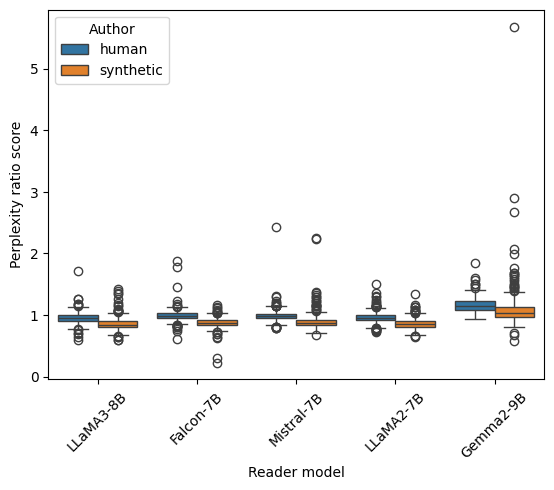

In [15]:
ax = sns.boxplot(data = data_df, x = 'Reader model', y = 'Perplexity ratio score', hue = 'Author')
ax.tick_params(axis = 'x', labelrotation = 45)
plt.show()

OK, cool - so they are all definitely different. Interestingly, we are the least confident about the difference in means for gemma2-9b (probably the most advanced model of the bunch). Looking at the plot, it's perplexity ratio scores tend to be the largest and have a bigger spread than the other models.

## 2. LLaMA3-8B

In [ ]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/pubmed-scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.head()

In [ ]:
data_df.info()

In [ ]:
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

### 2.1. Perplexity vs cross-perplexity

In [ ]:
plt.title('Perplexity vs cross-perplexity')
plt.scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
plt.scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
plt.legend(loc = 'lower right')
plt.xlabel('Perplexity')
plt.ylabel('Cross-perplexity')
plt.show()

### 2.2. Perplexity ratio score distribution

In [ ]:
plt.title('Perplexity ratio score distribution')
plt.hist(human_fragments['Perplexity ratio score'][human_fragments['Perplexity ratio score'] < 1.5], facecolor = 'green', label = 'Human text', alpha = 0.5)
plt.hist(synthetic_fragments['Perplexity ratio score'][synthetic_fragments['Perplexity ratio score'] < 1.5], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Fragments')
plt.show()

### 2.3. Binoculars score by fragment length

In [ ]:
plt.title('Perplexity ratio score by fragment length')
plt.scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
plt.scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
plt.legend(loc = 'upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Perplexity ratio score')
plt.show()

### 2.4. Fragment length distribution

In [ ]:
plt.hist(human_fragments['Fragment length (tokens)'], facecolor = 'green', label = 'Human text', alpha = 0.5)
plt.hist(synthetic_fragments['Fragment length (tokens)'], facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.xlabel('Fragment length (tokens)')
plt.ylabel('Fragments')
plt.show()